In [1]:
import numpy as np
from CoolProp.CoolProp import PropsSI
import handcalcs.render
from handcalcs.decorator import handcalc
import pint
import endf
from numpy import pi
from numpy import sqrt, log
import os
import matplotlib.pyplot as plt
import fluids
from thermophysicalProperties import Database
import warnings
from frozendict import frozendict
from numdifftools import Derivative

ureg = pint.UnitRegistry(auto_reduce_dimensions=True)
ureg.default_format = "~P"
Q_ = ureg.Quantity
ureg.define('USD = [currency] = $')

from paths import MSTDB_TP_DATA, MSTDB_TP_RK_DATA

warnings.filterwarnings("ignore")

import thermoToolsAdditions as tta

db = Database(MSTDB_TP_DATA, MSTDB_TP_RK_DATA)

In [5]:
# Salt compositions
coolant = frozendict({'NaF': 0.132, 'ZrF4': 0.032, 'KF': 0.4109, 'LiF': 0.4251})
fuel = frozendict({'NaCl': 0.25, 'KCl': 0.141, 'ZrCl4': 0.059, 'PuCl3': 0.398, 'NdCl3': 0.002, 'UCl3': 0.15})

# Fuel and coolant salt melting points (taken from cooland and fuel optimization notebooks)
Tboilf = 2164
Tmeltf = 788
Tmeltc = 721.47
kf = db.get_tp('thermal_conductivity', fuel, uncertainty=False)
kc = db.get_tp('thermal_conductivity', coolant, uncertainty=False)

# Density functions
rhoc = db.get_tp('density', coolant, uncertainty=False)
rhof = db.get_tp('density', fuel, uncertainty=False)

# Define volumetric thermal expansion coef (beta)
betaf = db.get_tp('beta', fuel, uncertainty=False)
betac = db.get_tp('beta', coolant, uncertainty=False)

# Viscosity of coolant
nuc = db.get_tp('viscosity', coolant, uncertainty=False)

# Heat capacity of coolant
cpc = db.get_tp('liquid_heat_capacity', coolant, uncertainty=False)

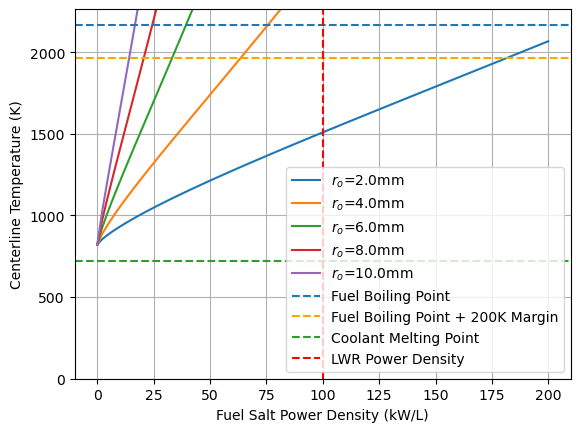

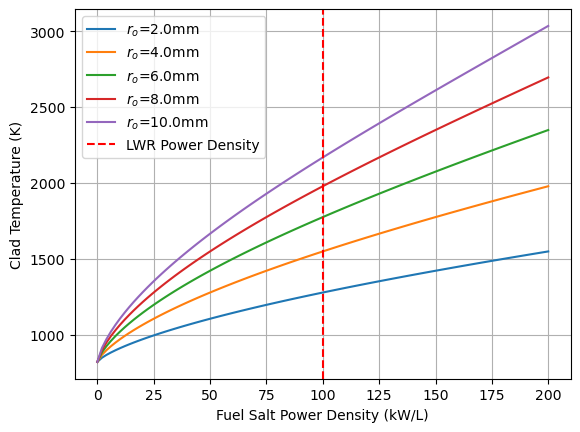

In [10]:
g = 9.8
Tinf = Tmeltc + 100 # 100K over melting temp
L = 3 # meters

# Initial guess of h: since the Rayleigh number depends on h, 
h = 1 # W/m2K

def Ts(h, qgen, ro):
    return Tinf + qgen*ro/(2*h)

def centerlineTemp(Ts, qgen, ro):
    return qgen*ro**2/(4*kf(Ts)) + Ts

def alphac(T):
    return kc(T)/(cpc(T)*rhoc(T))

# Dimensionless numbers
def Pr(T):
    return nuc(T)/(alphac(T))

def RaL(T, h, qgen, ro):
    return g*betac(T)*(Ts(h, qgen, ro) - Tinf)*L**3/(alphac(T)*nuc(T))

def GrL(T, h, qgen, ro):
    return RaL(T, h, qgen, ro)/Pr(T)

def NuL(T, h, qgen, ro):
    return (0.825 + 0.387*RaL(T, h, qgen, ro)**(1/6)/(1+(0.492/Pr(T))**(9/16))**(8/27))**2

# Need two loops, one over volumetric  heat generation rate (in W/m3) and one for fuel pin radius ro
qgens = np.linspace(0, 200E+06, 100) # W/m3
ros = np.linspace(0.002, 0.01, 5) # 2mm-10mm

for ro in ros:
    cladTemps = np.zeros(len(qgens))
    centerlineTemps = np.zeros(len(qgens))
    for index, qgen in enumerate(qgens):
        hguess = 1 # initial guess of h
        Tsguess = 500 # initial guess of surface temp
        for i in range(100):
            Teval = 1/2*(Tsguess + Tinf) # Properties evaluated at average temp
            Nu = NuL(Teval, hguess, qgen, ro)
            hguess = kc(Teval)/L*Nu # Update guess of h
            Tsguess = Ts(hguess, qgen, ro)
        cladTemps[index] = Tsguess
        centerlineTemps[index] = centerlineTemp(Tsguess, qgen, ro)

    plt.figure(1) # Select the first figure
    plt.plot(qgens/(1E+06), centerlineTemps, label=f'$r_o$={ro*1E+03}mm')

    # Plot cladTemps against qgens in a new figure
    plt.figure(2) # Select the second figure
    plt.plot(qgens/(1E+06), cladTemps, label=f'$r_o$={ro*1E+03}mm')

plt.figure(1)
plt.grid()
plt.ylim(0,Tboilf+100)
plt.axhline(Tboilf, label='Fuel Boiling Point', linestyle='dashed')
plt.axhline(Tboilf-200, label='Fuel Boiling Point + 200K Margin', linestyle='dashed', color='orange')
plt.axhline(Tmeltc, label='Coolant Melting Point', linestyle='dashed', color='tab:green')
plt.axvline(100, label='LWR Power Density', linestyle='dashed', color='red')
plt.axvline
plt.xlabel('Fuel Salt Power Density (kW/L)')
plt.ylabel('Centerline Temperature (K)')
plt.legend()
plt.savefig('centerlineTemperature.png', dpi=300)

plt.figure(2)
plt.grid()
plt.axvline(100, label='LWR Power Density', linestyle='dashed', color='red')
plt.axvline
plt.xlabel('Fuel Salt Power Density (kW/L)')
plt.ylabel('Clad Temperature (K)')
plt.legend()
plt.savefig('cladTemperature.png', dpi=300)